#  OpenPulse Grammar (for QMIO)
In this notebook, we'll introduce the OpenPulse grammar from OpenQasm 3 for pulse-level control of quantum devices. Each functionality will be followed by some examples and a description of what can be used in QMIO.

## Introduction to OpenPulse

**OpenQASM** is a programming language for intermidate communication of high-level compilers with quantum hardware. It tranforms high-level instructions (gates, circuits...) into pulse-level operations that the quantum device can implement. <br>
<br>
Inside OpenQASM, there are various grammars in which the instructions can be described at different levels, one of them is OpenPulse. **OpenPulse grammar** is designed to write instructions at pulse-level, with a set of functionalities (called abstractions) implemented by the hardware provider.
<br>
<br>
**What's pulse-level control?**<br>
In many quantum devices (specially in superconducting qubits like the ones in QMIO), the physical representation of the quantum gates is a driving of the spin system by some external pulse (microwaves signals, oscillatory magnetic fields, laser...). The pulse interacts with the spin and changes its state to de desired outcome for the gate. This pulses are characterized by their amplitude, duration and overall waveform; the desired gates are implemented by adjusting this parameters and, therefore, require calibrations.<br>
<br>
**What does *software abstractions* mean in OpenPulse?**<br>
OpenPulse grammar takes the physical concepts of the qubit pulse-driving and sets a series of abstractions to represent them on the code. This abstractions are used to reference the physical channels, characteristics or operations on the qubits, and are defined by the hardware provider, OpenPulse grammar lets us access and operate with them. On this course we'll see each of this functionalities and describe how to use them in QMIO. 

## Creating a workspace with OpenPulse and usage recommendation

First, we're going to establish a workspace to code with OpenPulse. We'll use **Python** to manage the OpenPulse instructions, send them to the real hardware (QMIO) and retrieve the results. The OpenPulse instructions will be stored as python string variables during the code execution, which can be managed in multiple ways.<br>
<br>
**How to set up a connection with QMIO?**<br>
You'll need access to the QMIO CPD nodes with a **@qmio.cesga.es** account. Next, you'll need to load the following modules:<br>
<br>
**module load qmio/hpc gcc/12.3.0 pytket/1.23.0-python-3.9.9 qmio-run/0.5.1-python-3.9.9 qiskit/1.2.4-python-3.9.9 qmio-tools/0.2.1-python-3.9.9**
<br>
<br>
Remember to load this modules each time you send the pyhton script or run the jupyter notebook (always in a *compute* node for this).<br>
Next, in the python scrip/notebook cell, import and call the QmioRuntimeService class as the service:

In [1]:
from qmio import QmioRuntimeService
service = QmioRuntimeService()

Now we are ready to send the instructions to QMIO, let's see an example for a simple instruction, later we'll explain how the OpenPulse grammar works. We'll define the set of instructions directly as a python string:

In [2]:
# In this script we apply a X gate to the qubit 8 and measure it.

instruction = '''
OPENQASM 3;
x $8;
measure $8;
'''

To send the instruction to QMIO and retrieve the results we'll use the method *QmioRuntimeService.run*, which has the following relevant arguments:

- **'circuit'**: OpenPulse instructions, as a character string for our case.
- **'shots'**: number of executions for the instructions in the qpu, will determine the number of result items.
- **'res_format'**: the format for the instruction, always "raw" for our case.

The *run* method will output a dictionary with the following keys:

- **'results'**: array with the numerical results of the measurements.
- **'execution_metrics'**: dictionary with the executions information ('optimized_circuit' and 'optimized_instruction_count').

The following usage is recommended:

In [3]:
with service.backend(name = "qpu") as backend: # Get the QMIO qpu backend
    res = backend.run(circuit = instruction, shots = 1024, res_format = 'raw') # Send the instructions and retrieve results
    try :
        res = res["results"] # Access numerical values from the job result
    except :
        print(res) # Print output message in case of error during execution

Then, we are ready to process and visualize the results with other python libraries.

[-0.61955987 -0.85031255 -0.5926405  ... -1.50608426 -1.57901669
 -1.28422415]


(array([ 17.,  67., 228., 260., 215., 104.,  59.,  41.,  23.,  10.]),
 array([-2.94115898, -2.41962874, -1.89809849, -1.37656824, -0.855038  ,
        -0.33350775,  0.1880225 ,  0.70955274,  1.23108299,  1.75261324,
         2.27414348]),
 <BarContainer object of 10 artists>)

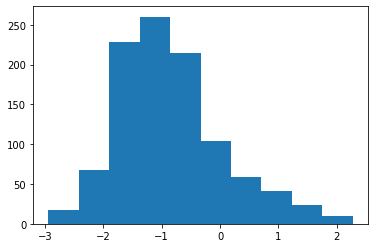

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

print(res[0])
plt.hist(res[0])

**How to work with Python/OpenPulse scripts?**<br>
The example from before is a basic case for interactive usage (not recommended). Here we detail some other options that may be more optimal depending on the use:
- **Import OpenPulse script**: instead of writing an OpenPulse script directly as a python string, you could write it in an external file and import it on the python script. This can be use either in python scripts and interactive notebook.


In [5]:
with open('./example_script.op', 'r') as file:
    lines = file.readlines()
    imported_instruction = ''.join(lines)
    
print(imported_instruction)

OPENQASM 3;
x $8;
measure $8;


- **Use f-strings**: another option is to use the f-string from python to easily change the OpenPulse script. This is especially useful when we want to execute the same instructions with some variant parameters that are stored as pyhton variables. It can also be used for python scripts and interactive notebooks. To do this, you just need to write the 'f' option before the string chain and add '{var}' where you want to state the external python variable. For example, we can define the qubit where we want to apply the X gate as an external python variable.

In [6]:
qubit = 7

base_instruction = f'''
OPENQASM 3;
x ${qubit};
measure ${qubit};
'''

print(base_instruction)


OPENQASM 3;
x $7;
measure $7;



In [7]:
# You can also define a function to get the instruction for a set variable
def X_gate(_qubit):
    base = f'''
    OPENQASM 3;
    x ${_qubit};
    measure ${_qubit};'''
    return base

print(X_gate(10))


    OPENQASM 3;
    x $10;
    measure $10;


For this last method there is an especific complication when we work with OpenPulse internal functions, which also use '{}' as delimiters. For example, one *call* function is defined as follows:

In [8]:
inst = '''
OPENQASM 3;
defcalgrammar "openpulse";

cal {
    extern frame q8_drive;
}

'''

print(inst)


OPENQASM 3;
defcalgrammar "openpulse";

cal {
    extern frame q8_drive;
}




But, for the f-string usage, we need to double the delimitation brackets in order to be correctly registered:

In [9]:
qubit = 8

f_inst = f'''
OPENQASM 3;
defcalgrammar "openpulse";

cal {{
    extern frame q{qubit}_drive;
}}

'''

print(f_inst)


OPENQASM 3;
defcalgrammar "openpulse";

cal {
    extern frame q8_drive;
}




**Important**: the job submission at QMIO has a queue system, for which the interactive use with jupyter notebooks is **not recommended**. When the cell with the *run* method is executed, the job is submitted and will wait until resources are available, the waiting time may depend on the demand. The main problem is that you are not reserving any time of usage when calling the notebook, you only reserve time when the *run* method is called, this can also bring problems related with the number of job quotas if the method is use multiple times in the notebook.<br>
The recommended use is to run a python script, submitting it with sbatch (or srun) and reserving a specific time for the QPU. Especially for experiments with multiple executions.

## OpenPulse functions

### Calibration blocks

In OpenQASM we can define **calibration blocks** to modify or design the pulse instructions of a gate. The grammar for this blocks must be specify through the *defcalgrammar* instruction at the start of the code. There are two types of calibration blocks:

- **cal**: has no name or inputs, it's used to capture values from the device calibration (qubit ports, frequencies... ) or define values that will be needed in the gate pulse instructions. The values declared inside the *cal* blocks can only be referenced form other *cal* or *defcal* blocks.
- **defcal**: the name is composed of the instruction and specific qubit it'll be applied to ($qubit). It's use to declare the pulse-level instructions for the gate. The

Let's see an example, here we'll import the calibrated frame from a qubit, change the driving frequency and define a constant pulse:

```
OPENQASM 3;
defcalgrammar "openpulse";

cal {
    extern frame q8_drive;
    set_frequency(q8_drive, 4.25e9);
}

defcal pulse $8{<br>
    waveform wf = constant(6.4e-08, 0.1);<br>
    play(q8_drive, wf);<br>
}

pulse $8;
```

The *defcalgrammar "openpulse"* set the OpenPulse grammar for the calibration blocks. The frame variable *q8_drive* can only be accessed in other *cal* and *defcal* blocks. 

### Ports

A **port** represents an input or output component from the communication with the qubit, it gives us the channel to control and measure the qubit. The specific mapping for the ports and channel specifications (NCO, DAG-ADG converters, amplifiers...) depends on the hardware provider. <br>
<br>
We can access this ports on the calibration blocks using the variables named by the provider: 

```
OPENQASM 3;
defcalgrammar "openpulse";

cal {
    extern port drive_port8;
}
```

### Frames

A **frame** also reference a qubit's channel, but also keeps track of the qubit's frame of reference information, which simplifies the way we have to define the pulses. It contains the following features:

- **port**: specifies whether the communication is to drive, measure or read the qubit (later we'll see how each works).
- **frequency** (float): it's the qubit's resonance frequency where we find the transition $|0\rangle\rightarrow|1\rangle$.
- **phase** (angle): is the accrued phase from the qubit's rotation.
- **duration** (time): it's used to keep track of the qubit evolution through time. 

The frame keeps track of two properties:<br>
<br>
Track the time of the specific qubit, so programs don't need to deal with absolute times and keep track of each qubit's time evolution.<br>

Track the natural time evolution of the qubit's hamiltonian, this let's us not need to worry with the accrued relative phase $e^{2\pi ft+\theta}$ produced by just letting the qubit evolve with time. This means that we can define our pulses as if the state $|0\rangle$ is 'constant' in time, as the frame will automatically include the relative phase in each instant of the pulse. <br>
<br>
There are 3 types of frames:

- **qQUBIT_drive**: frame for qubit driving, contains the qubit's resonance frequency. Used to implement any pulse-driving.
- **rQUBIT_measure**: frame for the resonator's measuring pulse. Used to specify the measuring pulse shape and frequency.
- **rQUBIT_acquire**: frame for resonator's measurement acquisition. Used for retrieving the measurement output from the qubit's resonator.

Here is an example on how to access this frames:

```
OPENQASM 3;
defcalgrammar "openpulse";

cal {
    extern frame q8_drive;
    extern frame r8_measure;
    extern frame r8_acquire;
}

```

#### Frame manipulation

There is a set of functions to access and modify the different features of the frame:

- **set_phase(frame, angle)**: sets the accrued angle $\theta$ from the frame to an angle.

- **shift_phase(frame, angle)**: changes the accrued angle $\theta$ from the frame by an angle.

- **get_phase(frame) > angle**: retrieves the accrued angle $\theta$ from the frame.


- **set_frequency(frame, float)**: sets the frame frequency to a float.

- **shift_frequency(frame, float)**: changes the frame frequency by a float.

- **get_frequency(frame) > float**: retrieves the frame frequency.

**Important**: remember that these functions can only be used inside calibration blocks.

### Waveforms

When we want to define a pulse we'll need to set a frame (like we saw before) and a **waveform**, which establish the amplitude profile of the pulse we want to apply. For example, a **constant** pulse will have a constant amplitude profile, meaning that the maximum amplitude for the pulse amplitude will remain constant during the pulse application. A **gaussian** pulse, on the other hand, starts with zero maximum amplitude which will grow until some mean value and the will decrease again with a gaussian profile. Here are some examples for this waveforms: 

<p align="center">
<img src="./media/waveforms.png" width="480">
<p>


The *waveform* variable type from OpenPulse can be expressed as:
    
- An **array of complex values**: the waveform is determined by the complex value of the array in each unit time. In other words, each value of the array determines the pulse's amplitude in each time window of lenght **dt** (minimum time resolution, provided by hardware). A pulse defined by a 100 values array will have length 100dt. This option allows for complex time-dependent waveforms (DRAG for example), but requires to compute the especific complex amplitude for each instant. For QMIO, this **dt** is 0,5ns.
<br>
    
- An **extern function**: there are some functions already implemented in OpenPulse grammar that can be accessed through the *extern* function. For all of them, apart from other parameter, the **duration** of the pulse must be especified. 
    
    
There is a bunch of built-in waveforms, let's see each of them:

#### 1) constant(duration, amplitude)
- duration: total pulse duration, by default the float will be read in seconds, but it can be specified the units at the end of it. For example, we can express one nanosecond as follows: 1e-9 (in seconds), 1ns (in nanoseconds) or 2dt (2 time units of the hardware, 0.5ns for QMIO).
- amplitude: the constant amplitude of the pulse, proportional to some hardware defined values for the pulse-generating potential. In QMIO there are limits set by the provider, and the backend will raise an error if the limit is exceded. In general, it should not surpass 1.0, but lower values are recommended to avoid crosstalk, reflections or other fenomena that may happen for high energy pulses.

**Important**: for QMIO, this function has the argument exchanged from the OpenPulse documentation and the rest of external functions.

#### 2) gaussian(amplitude, duration, sigma)
- duration: total duration, same as the constant.
- amplitude: the maximum amplitude of the gaussian profile, which will be met at half the duration of the pulse. The same recommendations are applied to this limits, but be aware that they may vary depending on the waveform.
- sigma: the standard deviation of the gaussian, i.e., the width of the pulse. It can be used to change how flat or dense the pulse is, for example, a big enough sigma will result in a constant pulse. There is a limit on how small the width can be, but may vary depending on the maximim amplitude.

#### 3) sech(amplitude, duration, sigma)
- duration: total duration.
- amplitude: the maximum amplitude of the profile.
- sigma: the standard deviation of the waveform profile.

#### 4) gaussian_square(amplitude, duration, square_width, sigma)
- duration: total duration.
- amplitude: the maximum amplitude of the profile.
- square_width: the width of the squared waveform component.
- sigma: the standard deviation of the waveform profile.

#### 5) drag(amplitude, duration, sigma, beta)
- duration: total duration.
- amplitude: the maximum amplitude of the profile.
- sigma: the standard deviation of the waveform profile.
- beta: the Y correction amplitude.

#### 6) sine(amplitude, duration, frequency, phase)
- duration: total duration.
- amplitude: the maximum amplitude of the profile.
- frequency: the frequency of the sine profile.
- phase: the phase offset of the sine profile.

#### Example of waveform usage
The waveforms must be declare in the calibration blocks:
```
OPENQASM 3;
defcalgrammar "openpulse";

cal {
    waveform wf = gaussian(0.1, 200.0e-9, 32.0e-9);
}
```

#### Waveform manipulation
There are also some implemented functions to manipulate and operate with waveform:
- **mix(waveform, waveform)>waveform**: multiplies two waveforms, $\text{wf}(t_i) = \text{wf}_1(t_i) \times \text{wf}_2(t_i)$.


- **sum(waveform, waveform)>waveform**: adds two waveforms, $\text{wf}(t_i) = \text{wf}_1(t_i) + \text{wf}_2(t_i)$.


- **phase_shift(waveform, angle)>waveform**: adds a relative phase to a waveform, $\text{wf}(t_i) = \text{wf}_1(t_i)\cdot e^{i\theta}$.


- **scale(waveform, float)>waveform**: scales the amplitude of the waveform by a real factor,  $\text{wf}(t_i) = A\cdot\text{wf}_1(t_i)$.

### Play
To schedule the pulses, the instruction **play(frame, waveform)** can be used only inside *defcal* blocks. In *play* all the require information for the pulse communitation is contained: port, frequency, time tracking and waveform. Here is a simple example: 

```
OPENQASM 3;
defcalgrammar "openpulse";

cal {
    extern frame q8_drive;
}

defcal gaussian_pulse $8 {
    waveform wf = gaussian(0.1, 200.0e-9, 32.0e-9);
    play(q8_drive, wf);
}

gaussian_pulse $8;
```

### Measurement

To retrieve the measurements from the qubit, the most direct method is the **measure** instruction. This function includes all the measurement process: driving pulse of the resonator, measurement acquisition and bisector projection.<br>

To use it, you just need to specify the qubit to measure, for example:

```
OPENQASM 3;
defcalgrammar "openpulse";

cal {
    extern frame q8_drive;
}

defcal gaussian_pulse $8 {
    waveform wf = gaussian(0.1, 200.0e-9, 32.0e-9);
    play(q8_drive, wf);
}

gaussian_pulse $8;
measure $8;
```

The output of each instruction execution is a real value, approximately in [-5,5]. This is the projection of the $|0\rangle$ and $|1\rangle$ blobs in the IQ plane to their bisector. Values around 1.0 are probably outcomes of a $|0\rangle$ measurement, and values around -1.0 are probably outcomes from a $|1\rangle$ measurement.<br>
<br>
Let's see an example:

In [10]:
hadamard_inst = '''
OPENQASM 3;
h $8;
measure $8;
'''

with service.backend(name = "qpu") as backend: 
    res = backend.run(circuit = hadamard_inst, shots = 1024, res_format = 'raw') 
    try :
        res = res["results"] 
    except :
        print(res) 

(array([  2.,   3.,  17.,  31.,  62.,  88.,  76.,  62.,  61.,  40.,  48.,
         56.,  80., 108., 119.,  83.,  54.,  22.,   8.,   4.]),
 array([-3.03988793, -2.74773585, -2.45558377, -2.16343169, -1.87127961,
        -1.57912753, -1.28697545, -0.99482337, -0.70267129, -0.41051922,
        -0.11836714,  0.17378494,  0.46593702,  0.7580891 ,  1.05024118,
         1.34239326,  1.63454534,  1.92669742,  2.2188495 ,  2.51100158,
         2.80315366]),
 <BarContainer object of 20 artists>)

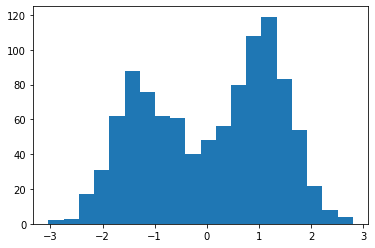

In [14]:
plt.hist(res[0], bins = 20)

When applying a Hadamard gate we see the superposition of the two state distributions around the positive (0) and negative (1) values, corresponding in this case to the state $|+\rangle=\frac{1}{\sqrt{2}}\left(|0\rangle+|1\rangle\right)$. 
<br><br>
Usually, a discrimination method should be used to decide whether the measured value corresponds to a 0 or a 1, this can be done by hypothesis contrast from the random distributions, trainning a classification model, etc. This is the main source of the **readout error**, which consist in wrongly classifying a measurement. As we can see, the distributions for both values present a big overlap, creating a area where the risk of wrong classification is high. One method to reduce this error could be to only register measurements outside some interval $[-\varepsilon,\varepsilon]$ around 0, unfortunatelly, this would only work if the random distributions where symetrical around it, which they are not.<br><br>
Fot the sake of simplicity, and to focus on the OpenPulse grammar use, on the course's experiment we'll classify the measurements by its sign (negative is a 1, positive a 0), but have in mind that better classification techniques may and should be used for more rigorous experiments.


#### Multiple qubits operations and measurements

To operate and measure more than one qubit in the same execution (to test entangled states, study crosstalk...), we can use the same instructions, declaring all qubits affected by them. For multiple qubit operations, all the used qubits must appear on the *defcal* block definition and declaration; for measurements, the qubits must be separated by a comma, as the measure instruction is applied for each qubit independently. 

```
OPENQASM 3;
defcalgrammar "openpulse";

cal {
    extern frame q8_drive;
}

defcal gaussian_pulse $8 $9{
    waveform wf = gaussian(0.1, 200.0e-9, 32.0e-9);
    play(q8_drive, wf);
    play(q9_drive, wf);
}

gaussian_pulse $8 $9;
measure $8, $9;
```

#### Capture instruction (not working in QMIO)

There are other options in OpenPulse for lower-level measurements, which must have been implemented by the hardware provider. This extern functions can only be used inside *defcal* blocks, like with the *play* instruction. Then especific function arguments and outputs should also be especify by the provider, but the acquisition frame is allways needed. Here is a general idea of the usual options and which are implemented in QMIO:

- **capture_v0(frame)**: the raw output from the measurement, for superconducting qubits, it could be the raw digitalized signal (after the ADG). **Not implemented in QMIO**.  


- **capture_v1(frame, filter)>complex[float[32]]**: the IQ value of the measurement, which is a complex number $I+iQ$. The computational states appear in the IQ complex plain as two separated blobs, but also higher energy eigenstates can be seen and measured with this acquision level. **Implemented in QMIO but not working properly**. 


- **capture_v2(frame, filter)>bit**: the discriminated bit from the measurement. 


Let's see an example of an $IQ$ acquisition using *capture_v1*:

```OPENQASM 3;
defcalgrammar "openpulse";

cal {
    extern frame r8_measure;
    extern frame r8_acquire;
    complex[float] iq;
    waveform wf1 = constant(8000dt, 1.0);
}

defcal measure $8 {
    barrier r8_measure, r8_acquire;
    play(r8_measure, wf1);
    iq = capture_v1(r8_acquire, 8000dt);
    return iq;
}
measure $8;
```

Remember that a pulse must be played on the resonator's measure channel in order to be an observable splitting on the acquisition channel.

### Time
As we saw before, each qubit frame keeps track independently of its time to automatically adjust the pulses with the physical rotation frame. This means that each qubit has an internal clock with a time variable that need to be syncronize in order to perform operations with multiple qubits. OpenPulse grammar has tools to delay and syncronize this clocks.<br>
Firstly, there are other functions that make the clock advance, these include any *decal* blocks, *play* or *capture* instructions. By default, *cal* blocks don't make the clock advance, as they are set before the instruction execution.<br>
<br>
The **delay[time] frame** instruction makes the clock advance by a set time. You can either delay an especific frame from the qubit:

```
OPENQASM 3;
defcalgrammar "openpulse";

defcal delay_func $8{
    extern frame q8_drive;
    delay[13ns] q8_drive;
}

delay_func $8;
```

Or its global frame:

```
OPENQASM 3;
defcalgrammar "openpulse";

delay[13ns] $8;
```

The **barrier frame1, frame2, ...** instructions aligns the clocks to the latest time from the listed frames. Note that *decal* blocks have an implicit *barrier* for each frame they reference.


```
OPENQASM 3;
defcalgrammar "openpulse";

cal {
  extern frame q8_drive;
  extern frame q9_drive;
  waveform wf = constant(400ns, 0.3);
}

defcal two_qubit_gate $8 $9 {
  barrier $8, $9; // This barrier for qubit 8 and 9 frames is implicit in defcal (written here for clarification)
  play(q8_drive, wf);
  play(q9_drive, wf);
}

two_qubit_gate $8 $9;
measure $8, $9;
```